# 3-Cell Motifs in PyC Subgraph (Generalized ER & CFG)

In [2]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *
from utils.fileio import *

## Create PyC Subgraph

In [3]:
# fetch and preview the synapses table
pcy_synapses = read_pyc_graph("data/pyc_graph_v185.csv")
pcy_synapses.head()

,segmentation,id,valid,pre_pt_position,pre_pt_supervoxel_id,pre_pt_root_id,ctr_pt_position,post_pt_position,post_pt_supervoxel_id,post_pt_root_id,size,spine_vol,exclude_conn
0,185,1484,1,"[91332, 57836, 1584]",97170491155950710,648518346349539437,"[91369, 57798, 1582]","[91332, 57748, 1584]",97170491155951077,648518346349531254,798,0.133004,0
1,185,2254,1,"[64762, 45414, 711]",89838917557174822,648518346349537978,"[64742, 45419, 708]","[64720, 45430, 708]",89838917557173796,648518346349537300,129,0.016346,0
2,185,3785,1,"[69646, 63086, 721]",91264984138384361,648518346349533058,"[69604, 63106, 721]","[69558, 63120, 721]",90983509161691227,648518346349538715,62,0.020969,0
3,185,3863,1,"[66776, 39946, 1138]",90396382837344883,648518346349539333,"[66750, 39982, 1139]","[66722, 39990, 1139]",90396382837366381,648518346349539806,62,0.018033,0
4,185,4062,1,"[89112, 48970, 2154]",96597662777759466,648518346349523975,"[89162, 48958, 2154]","[89198, 48936, 2154]",96597662777759456,648518346349537716,62,0.008805,0


In [4]:
pcy_synapses = format_synapses(pcy_synapses)

# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pcy_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))

In [5]:
print(nx.info(g_actual))

Name: 
Type: DiGraph
Number of nodes: 334
Number of edges: 1738
Average in degree:   5.2036
Average out degree:   5.2036


## 3-Cell Motifs

In [6]:
%%time
# count 3-cell motifs in the observation
obs_three_counts, _ = count_three_neuron_motifs(*graph_to_sets(g_actual), motifs)
# analytically compute 2-cell motif counts in Erdos-Renyi model
three_pr, two_pr = compute_three_neuron_motif_probabilities_GE(g_actual)
er_three_counts = compute_expected_three_neuron_motifs(g_actual, three_pr)

CPU times: user 3min 35s, sys: 196 ms, total: 3min 35s
Wall time: 3min 36s


In [ ]:
%%time
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs_GE, g_actual, samples=s, niters=int(1e4), threads=10)

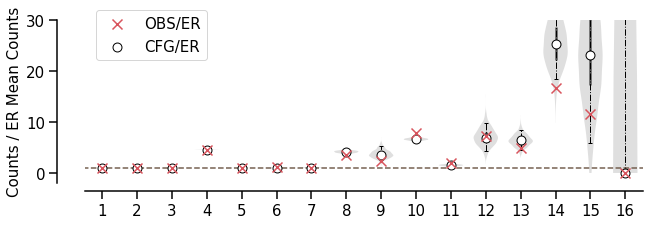

In [16]:
# relative counts in ratio (/ER expected counts)
res_three = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                            subtitle='', ylim=[-2, 30], fname="3_violin_GE", figsize=(10,3))

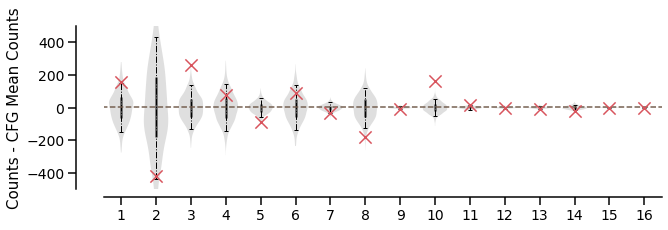

In [17]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                     subtitle='', ylim=[-500, 500], fname="3_violin_diff_GE");

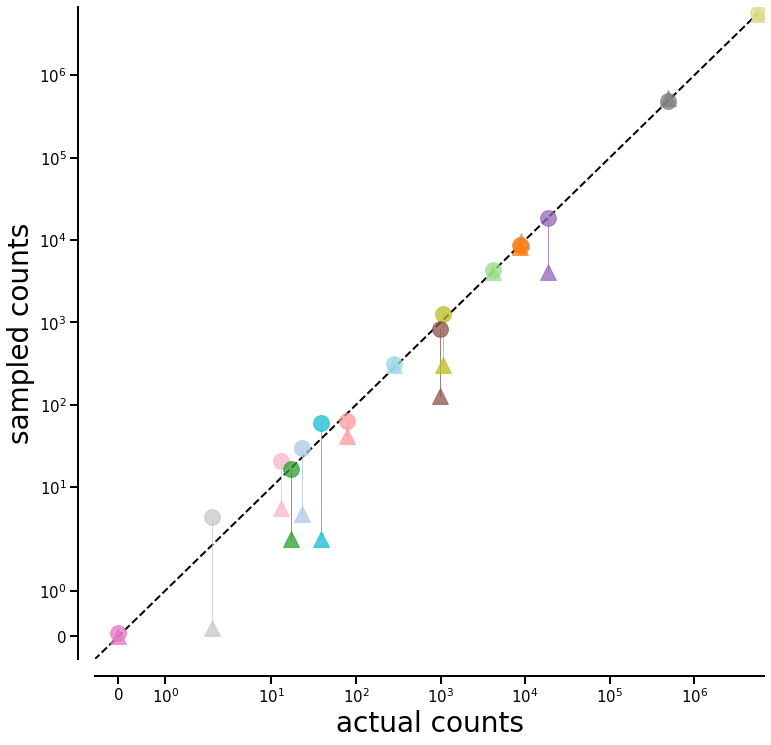

In [18]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts, config_three_counts, figsize=(12,12), fname="3_scatter_GE")

In [19]:
res_three

,obs,er_exp,config_exp,config_std,config_z
1,5622854,5.604778e+06,5622699.612,94.631933,1.631458
2,488467,5.227965e+05,488887.890,271.523220,-1.550107
3,8828,9.669864e+03,8569.208,80.930318,3.197714
4,18644,4.063738e+03,18565.275,89.024248,0.884310
5,4209,4.063738e+03,4300.006,35.587420,-2.557252
6,8755,8.127476e+03,8662.560,83.799312,1.103112
7,284,3.006584e+02,315.254,19.462998,-1.605816
8,1071,3.006584e+02,1251.151,76.687895,-2.349145
9,13,5.561104e+00,20.722,4.583418,-1.684769
10,999,1.263510e+02,837.490,32.265693,5.005626


In [20]:
# p-values
np.minimum((config_three_counts > obs_three_counts).sum(0) / 1000, 
           (config_three_counts < obs_three_counts).sum(0) / 1000)

1     0.046
2     0.053
3     0.001
4     0.184
5     0.005
6     0.137
7     0.054
8     0.010
9     0.020
10    0.000
11    0.038
12    0.388
13    0.078
14    0.021
15    0.066
16    0.000
dtype: float64

## Clustering Coefficient

In [21]:
# clustering coefficient of the observed network
nx.transitivity(g_actual.to_undirected())

0.09538309604147807

In [22]:
# expected clustering coefficient of the networsk sampled from the generalized ER model
1-two_pr['pr_null']

0.03069536602470735

In [23]:
# expected clustering coefficient of the networsk sampled from the generalized CFG model
clustering_coef(config_three_counts).mean()

0.08400544922878357

In [24]:
two_pr['pr_uni'], two_pr['pr_bi']

(0.015068961176745608, 0.0005574436712161263)